In [3]:
import vaex
import numpy as np
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt
from scipy import interpolate
from os.path import join, abspath
import sys
from os import pardir, mkdir

In [4]:
# import utils
util_dir = abspath(pardir)
sys.path.insert(0, util_dir)

from utils import load_spectral_types

In [5]:
root_data_dir = abspath(join(pardir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [7]:
name = "Spectral-Class"
data_dir = join(root_data_dir, name)
try:
  mkdir(data_dir)
  print(f"Creating {name} dir in Data dir")
except FileExistsError:
  print("Directory already exist. Good to go!")

Directory already exist. Good to go!


In [8]:
# path to file produced by 1.1. Gaia DR3 and 2MASS.ipynb
gaia_dir = join(root_data_dir, "Gaia-2MASS")
files = glob(join(gaia_dir, "*.hdf5"))
# file = join(data_dir, "mamajek-spectral-class.hdf5")
files[:5]

['/home2/s20321005/Thesis-Project/Data/Gaia-2MASS/gaia-219-220.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Gaia-2MASS/gaia-079-080.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Gaia-2MASS/gaia-218-219.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Gaia-2MASS/gaia-182-183.hdf5',
 '/home2/s20321005/Thesis-Project/Data/Gaia-2MASS/gaia-045-046.hdf5']

In [9]:
gaia_raw = vaex.open_many(files)
gaia_raw

#,source_id,ra,dec,pm,pmra,e_pmra,pmdec,e_pmdec,parallax,e_parallax,Gmag,BPmag,RPmag,rv_gaia,e_rv_gaia,bp_rp,GLON,GLAT,teff_gspphot,teff_gspphot_lower,teff_gspphot_upper,logg_gspphot,logg_gspphot_lower,logg_gspphot_upper,mh_gspphot,mh_gspphot_lower,mh_gspphot_upper,distance_gspphot,distance_gspphot_lower,distance_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,RAVE6,SDSS13,Jmag,Hmag,Kmag,mh_gspspec,mh_gspspec_lower,mh_gspspec_upper,alphafe_gspspec,alphafe_gspspec_lower,alphafe_gspspec_upper,fem_gspspec,fem_gspspec_lower,fem_gspspec_upper,spectraltype_esphs
0,5764635079544432128,219.77805455719,-89.56922832436,7.511,1.522,0.021,-7.355,0.020949371,2.8775,0.0184,10.847249,11.118501,10.412085,-5.29,0.73,0.706416,303.15029042357,-26.74401558194,6141.6,6130.1,6152.1,4.043,4.0398,4.0469,-0.4365,-0.4457,-0.4269,344.0585,341.9788,346.0511,0.0799,0.0745,0.0847,,--,9.953,9.698,9.683,-0.26,-0.32,-0.22,0.33,0.26,0.4,nan,nan,nan,F
1,5764635393079767296,219.15195997564,-89.5318109641,11.203,-8.352,0.012,-7.467,0.012214055,0.4305,0.011,13.174702,13.789571,12.425439,67.09,0.91,1.364132,303.16401990137,-26.70832039314,4718.7,4713.3,4724.8,2.5833,2.5655,2.6014,-0.1946,-0.1952,-0.1941,2070.6995,2031.6134,2112.0928,0.3619,0.3574,0.3668,,--,11.418,10.819,10.704,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
2,5764635496158988544,219.83101507284,-89.50979783241,2.65,-2.095,0.022,1.623,0.024982337,0.2155,0.0218,14.993793,15.584641,14.263248,nan,nan,1.321393,303.18075914642,-26.69113646047,4881.6,4875.7,4888.8,3.0708,3.0509,3.0862,-0.1415,-0.15,-0.1356,3446.1995,3376.546,3517.8865,0.4145,0.4093,0.4207,,--,13.306,12.725,12.634,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
3,5764638554175708672,219.24632619569,-89.48870252979,11.672,-10.811,0.017,-4.399,0.01951931,1.9675,0.0166,14.446186,14.915824,13.815229,13.17,3.9,1.100595,303.18615009602,-26.66999019517,5226.6,5217.9,5235.5,4.5456,4.5418,4.5518,-0.1967,-0.2063,-0.1864,490.8246,487.5747,493.967,0.2623,0.2565,0.2679,,--,13.026,12.587,12.512,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
4,5764639241370488064,219.24010479539,-89.44765029195,14.783,-10.759,0.113,-10.139,0.12553297,1.2643,0.1066,17.817894,18.871086,16.80843,nan,nan,2.062656,303.2064053892,-26.63317348591,4119.2,4089.7,4135.9,4.6477,4.6411,4.6547,0.3467,0.2681,0.3855,822.1085,799.1945,831.1044,0.7264,0.6964,0.7513,,--,15.434,14.768,14.468,nan,nan,nan,nan,nan,nan,nan,nan,nan,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"94,994,937",576406227696244864,33.65804765403,89.33197663578,4.686,-4.139,0.072,-2.197,0.064973824,0.6416,0.0561,16.92992,17.625141,16.097548,nan,nan,1.527594,123.19695964994,26.50349463792,4337.4,4217.8,4422.2,4.3911,4.2846,4.4237,-0.3812,-0.4888,-0.3243,1117.2708,1065.5874,1205.549,0.305,0.1938,0.3925,,--,14.993,14.263,14.201,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
"94,994,938",576431585183142528,33.61268607589,89.48206639541,1.894,-1.763,0.02,0.693,0.017867079,0.6989,0.0159,14.399571,15.067607,13.604876,-14.88,3.59,1.462731,123.13723815775,26.64377331058,5178.8,5133.0,5367.7,3.5746,3.4492,3.8413,-0.4349,-0.4827,-0.291,1165.2085,893.3535,1341.377,0.9013,0.8756,0.9909,,--,12.616,12.051,11.924,nan,nan,nan,nan,nan,nan,nan,nan,nan,K
"94,994,939",576445638316125184,33.60957894134,89.57301292445,4.728,-2.691,0.018,3.887,0.015934618,0.7782,0.015,14.292352,14.78063,13.633098,-36.36,7.38,1.147533,123.10127650839,26.72887005884,5855.7,5835.1,5878.4,4.0048,3.9971,4.0145,-0.583,-0.6066,-0.555,1217.041,1196.2493,1234.8632,0.7542,0.7434,0.7665,,--,12.857,12.457,12.404,nan,nan,nan,nan,nan,nan,nan,nan,nan,G
"94,994,940",576447459382243200,33.57768719537,89.70251709954,17.162,10.764,0.021,13.367,0.021056626,0.9942,0.0197,14.856944,15.333351,14.206361,-6.87,13.13,1.12699,123.04990412536,26.85002805556,5420.3,5395.1,5501.3,4.2236,4.2103,4.2407,-1.28,-1.323,-1.1485,946.7403,929.4686,962.1341,0.4847,0.4702,0.5

In [16]:
cols = ["parallax", "e_parallax", "Jmag", "Kmag", "spectraltype_esphs", "GLON", "GLAT", "ra", "dec"]
gaia = gaia_raw[cols]
gaia["J-K"] = gaia["Jmag"] - gaia["Kmag"]
gaia["M_J"] = gaia["Jmag"] -10 - 5*np.log10(1/gaia["parallax"])
gaia["GLON"] = gaia["GLON"]*np.pi/180
gaia["GLAT"] = gaia["GLAT"]*np.pi/180
gaia['Dist'] = 1000/gaia['parallax']
gaia

#,parallax,e_parallax,Jmag,Kmag,spectraltype_esphs,GLON,GLAT,ra,dec,J-K,M_J,Dist
0,2.8775,0.0184,9.953,9.683,F,5.2909706962683325,-0.46677112710952035,219.77805455719,-89.56922832436,0.27000046,2.248076730173698,347.5238922675934
1,0.4305,0.011,11.418,10.704,K,5.291210320860521,-0.4661481285378393,219.15195997564,-89.5318109641,0.71399975,-0.41213399979919085,2322.8803716608595
2,0.2155,0.0218,13.306,12.634,K,5.291502475800941,-0.4658482123343068,219.83101507284,-89.50979783241,0.67199993,-0.026763871656873217,4640.371229698376
3,1.9675,0.0166,13.026,12.512,K,5.291596565621272,-0.4654791403803216,219.24632619569,-89.48870252979,0.51399994,4.495573728043695,508.25921219822106
4,1.2643,0.1066,15.434,14.468,,5.291950087178218,-0.46483656758398506,219.24010479539,-89.44765029195,0.9659996,5.943250704949416,790.9515146721507
...,...,...,...,...,...,...,...,...,...,...,...,...
"94,994,937",0.6416,0.0561,14.993,14.201,K,2.1501925743380537,0.46257324471636635,33.65804765403,89.33197663578,0.7919998,4.029321806898113,1558.6034912718205
"94,994,938",0.6989,0.0159,12.616,11.924,K,2.1491502376651344,0.4650215694246107,33.61268607589,89.48206639541,0.6920004,1.8380753778451964,1430.8198597796538
"94,994,939",0.7782,0.015,12.857,12.404,G,2.1485225884793544,0.46650678786448846,33.60957894134,89.57301292445,0.45300007,2.312456483290767,1285.0167052171678
"94,994,940",0.9942,0.0197,13.478,12.953,G,2.147625971250885,0.46862139382237294,33.57768719537,89.70251709954,0.5249996,3.465368481209726,1005.8338362502515


In [17]:
df_mask = gaia.filter("1/parallax*cos(GLAT) < 0.15").filter("1/parallax*abs(sin(GLAT)) < 0.2")
df_mask = df_mask.extract()
df_mask['z'] = df_mask['Dist']*np.sin(df_mask['GLAT'])
df_mask['r'] = df_mask['Dist']*np.cos(df_mask['GLAT'])
df_mask

#,parallax,e_parallax,Jmag,Kmag,spectraltype_esphs,GLON,GLAT,ra,dec,J-K,M_J,Dist,z,r
0,6.6145,0.0763,14.604,13.835,M,5.312093462437412,-0.4274852423543256,219.1950221424,-87.06837156946,0.76900005,8.706485195509723,151.18300703000983,-62.67800410065582,137.57823016958088
1,7.4939,0.0757,14.588,13.781,M,5.32684177812351,-0.3995586958202191,219.29242125116,-85.29034186967,0.80700016,8.961539764995575,133.44186605105486,-51.910465356605705,122.93101806154664
2,9.4186,0.0437,13.68,12.809,M,5.328628689981591,-0.3984568404974272,219.98674131246,-85.19249278327,0.8710003,8.549932071018873,106.17289193723059,-41.194714201530395,97.85539588683434
3,10.3979,0.0108,11.068,10.234,M,5.334101748825802,-0.38804058289517696,219.965861717,-84.52897673127,0.83399963,6.152728021611629,96.17326575558526,-36.38959826687522,89.02299806269086
4,7.3943,0.0139,11.838,11.034,M,5.335780523453312,-0.38350365301361994,219.62715184641,-84.25649218182,0.8039999,6.18248563104554,135.23930595188185,-50.60274870842963,125.41543644024937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,103,472",7.6735,0.018,12.452,11.632,M,2.181646197502715,0.3864478511005224,33.94647075114,84.67187047345,0.8199997,6.876967151573965,130.31862904802242,49.117170622565375,120.70811334367657
"1,103,473",17.4583,0.0298,12.424,11.581,M,2.176284754246674,0.39975437409574444,33.92242925702,85.48488808199,0.84299946,8.634009546637067,57.279345640755395,22.292668479988812,52.76324828016597
"1,103,474",8.9678,0.0206,12.476,11.617,M,2.1759805469450524,0.40028828291031976,33.86489396736,85.51948147518,0.8590002,7.23942940242012,111.51006935926314,43.45367339450074,102.69505264145754
"1,103,475",6.5031,0.0405,13.551,12.657,M,2.1688540575030726,0.4158889554882346,33.20065553444,86.48759183034,0.89400005,7.616601803057423,153.77281604158017,62.124720309573945,140.66484308388812


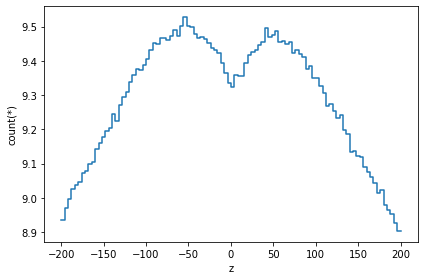

In [12]:
df_mask.viz.histogram("z", limits=[-200, 200], shape=100, show=True, f="log")

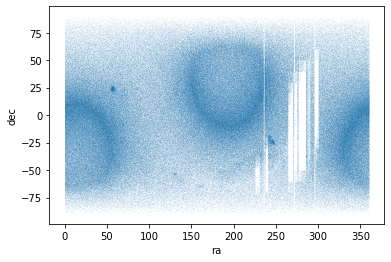

In [20]:
df_mask.viz.scatter(df_mask.ra, df_mask.dec, s=0.01, alpha=0.1, length_check=False)

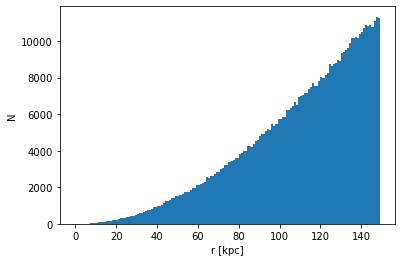

In [20]:
# count number of stars in spherical shell
dr = 1
r = np.arange(0.00, 150, dr)
N = np.zeros(len(r)-1)
for i, (r_low, r_high) in enumerate(zip(r[:-1], r[1:])):
  N[i] = df_mask.filter(f"Dist > {r_low}").filter(f"Dist <= {r_high}").count()
  
# plot number of stars in spherical shell
plt.bar((r[:-1]+r[1:])/2, N, width=dr)
plt.xlabel("r [kpc]")
plt.ylabel("N")
plt.show()


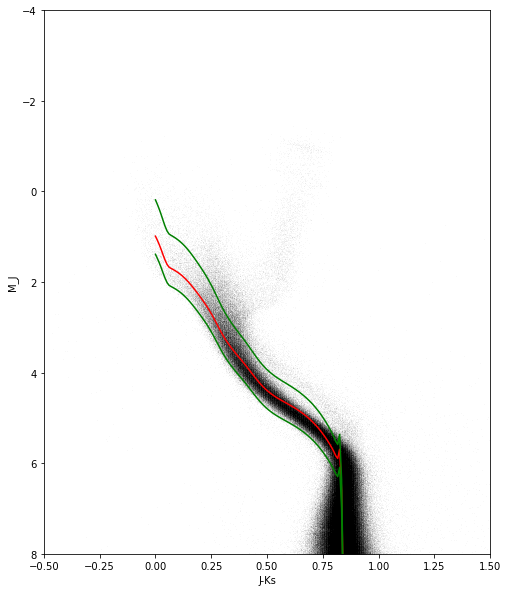

In [21]:
# HR diagram
JK = np.linspace(0, 0.86, 100)
MJ = main_locus(JK)
MJ_high = main_sequence_cut_r(JK)
MJ_low = main_sequence_cut_r(JK, low=True)
plt.figure(figsize=(8,10))
df_mask.viz.scatter("J-K", "M_J", c='k', alpha=0.1, s=0.01, length_check=False)
plt.plot(JK, MJ, c="red")
plt.plot(JK, MJ_low, c="green")
plt.plot(JK, MJ_high, c="green")
plt.xlabel("J-Ks")
plt.ylabel("M_J")
plt.xlim(-0.5, 1.5)
plt.ylim(-4, 8)
plt.gca().invert_yaxis()
plt.show()

In [22]:
df_s = load_spectral_types()
df_s

,SpT,M_J,J-H,H-Ks,J-K
0,O9V,-3.44,-0.164,-0.071,-0.235
1,O9.5V,-3.30,-0.161,-0.069,-0.230
2,B0V,-3.17,-0.159,-0.067,-0.226
3,B0.5V,-2.80,-0.153,-0.063,-0.216
4,B1V,-2.33,-0.148,-0.059,-0.207
...,...,...,...,...,...
95,T6V,15.34,0.100,-0.030,0.070
96,T7V,15.83,0.000,0.000,0.000
97,T7.5V,16.61,0.200,-0.050,0.150
98,T8V,17.30,0.200,-0.050,0.150


In [23]:
df_mask['M_J_upper'] = main_sequence_cut_r(df_mask['J-K'].to_numpy())
df_mask['M_J_lower'] = main_sequence_cut_r(df_mask['J-K'].to_numpy(), low=True)
df_mask

#,parallax,e_parallax,Jmag,Kmag,spectraltype_esphs,GLON,GLAT,J-K,M_J,Dist,z,r,M_J_upper,M_J_lower
0,6.6145,0.0763,14.604,13.835,M,5.312093462437412,-0.4274852423543256,0.76900005,8.706485195509723,151.18300703000983,-62.67800410065582,137.57823016958088,5.136395144099251,5.887631949181138
1,7.4939,0.0757,14.588,13.781,M,5.32684177812351,-0.3995586958202191,0.80700016,8.961539764995575,133.44186605105486,-51.910465356605705,122.93101806154664,5.508579853006963,6.225981684551785
2,9.4186,0.0437,13.68,12.809,M,5.328628689981591,-0.3984568404974272,0.8710003,8.549932071018873,106.17289193723059,-41.194714201530395,97.85539588683434,11.019718051592646,11.236107319629678
3,10.3979,0.0108,11.068,10.234,M,5.334101748825802,-0.38804058289517696,0.83399963,6.152728021611629,96.17326575558526,-36.38959826687522,89.02299806269086,6.371110157818358,7.010100143471235
4,7.3943,0.0139,11.838,11.034,M,5.335780523453312,-0.38350365301361994,0.8039999,6.18248563104554,135.23930595188185,-50.60274870842963,125.41543644024937,5.472413451209574,6.1931031374632495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"1,103,472",7.6735,0.018,12.452,11.632,M,2.181646197502715,0.3864478511005224,0.8199997,6.876967151573965,130.31862904802242,49.117170622565375,120.70811334367657,5.487772951778904,6.207066319799004
"1,103,473",17.4583,0.0298,12.424,11.581,M,2.176284754246674,0.39975437409574444,0.84299946,8.634009546637067,57.279345640755395,22.292668479988812,52.76324828016597,9.291071954903094,9.664610868093723
"1,103,474",8.9678,0.0206,12.476,11.617,M,2.1759805469450524,0.40028828291031976,0.8590002,7.23942940242012,111.51006935926314,43.45367339450074,102.69505264145754,11.387770377976748,11.570700343615226
"1,103,475",6.5031,0.0405,13.551,12.657,M,2.1688540575030726,0.4158889554882346,0.89400005,7.616601803057423,153.77281604158017,62.124720309573945,140.66484308388812,8.965830852090512,9.368937138264103


In [24]:
# Filter A star
JK_lower = (df_s[df_s['SpT'] == 'B9V']['J-K'].to_numpy()[0]+df_s[df_s['SpT'] == 'A0V']['J-K'].to_numpy()[0])/2
JK_upper = (df_s[df_s['SpT'] == 'A9V']['J-K'].to_numpy()[0]+df_s[df_s['SpT'] == 'F0V']['J-K'].to_numpy()[0])/2

mask_A = ((df_mask['J-K'] > JK_lower)
          *(df_mask['J-K'] < JK_upper)
          *(df_mask['M_J_lower'] > df_mask['M_J'])
          *(df_mask['M_J_upper'] < df_mask['M_J']))
df_A = df_mask[mask_A]
df_A

#,parallax,e_parallax,Jmag,Kmag,spectraltype_esphs,GLON,GLAT,J-K,M_J,Dist,z,r,M_J_upper,M_J_lower
0,5.9392,0.0439,6.778,6.789,A,0.1412982093861118,1.074330975824934,-0.011000156,0.6466396289434337,168.37284482758622,148.04547367264996,80.19945511270718,0.06500256027271278,1.2772750547933753
1,8.8279,0.0362,5.756,5.756,A,1.6435504519431232,0.9900832726717229,0.0,0.4852870667125613,113.27722334870128,94.70787690984973,62.146177523805186,0.18703286814037368,1.3882116983094308
2,7.3541,0.0217,7.674,7.547,A,4.124381132424658,-0.5817652501900104,0.12699986,2.0066474416131834,135.9785697774031,-74.72017623176018,113.60927208024346,1.1846460905725174,2.2951328096113794
3,6.6259,0.0287,7.164,7.034,A,3.51312435979722,-0.3541599117890833,0.13000011,1.2702244198193657,150.92289349371407,-52.34044234165063,141.55634170179485,1.1999704839358463,2.3090640763053147
4,9.6497,0.0383,6.991,6.88,A,3.3763567905059992,-0.278211536298417,0.11100006,1.9135692342313995,103.63016466833166,-28.460614810613947,99.64539343987457,1.1107089604377152,2.2279172367615594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"2,455",5.1248,0.0464,7.763,7.752,A,3.271555097327552,-1.1790599624229767,0.011000156,1.3113846180428244,195.12956603184517,-180.3480175398584,74.4992624743302,0.315939221709695,1.505399292463359
"2,456",6.3831,0.025,7.575,7.514,A,3.1330449980711492,-1.1387173122532164,0.06099987,1.6001580507686972,156.6636900565556,-142.26584346597846,65.60443251069418,0.9404121409348115,2.0731019463043743
"2,457",4.6508,0.0307,7.699,7.621,A,2.663338560115363,-0.798770749250566,0.07800007,1.0366382007124533,215.01677130816202,-154.05932783339614,149.99311801315625,0.9929802690668323,2.1208911536971202
"2,458",6.9438,0.0279,7.567,7.467,A,2.474581541477357,-0.4425509786959161,0.099999905,1.7749859297953465,144.01336444022004,-61.673158628216086,130.13942770048794,1.0667779549534984,2.187979959048635


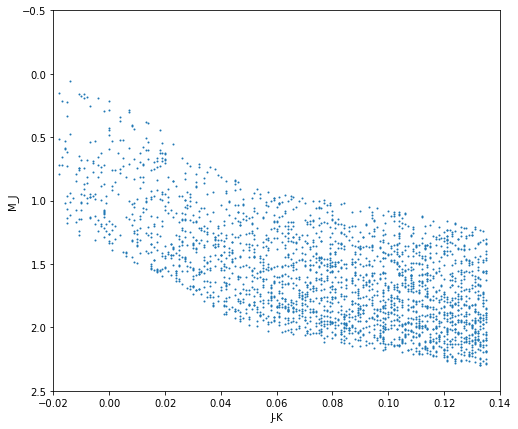

In [25]:
# HR diagram for gaia filter
plt.figure(figsize=(8,7))
df_A.viz.scatter("J-K", "M_J", s=1, length_limit=500_000)
plt.xlabel("J-K")
plt.ylabel("M_J")
plt.xlim(-0.02, 0.14)
plt.ylim(-0.5, 2.5)
plt.gca().invert_yaxis()
plt.show()

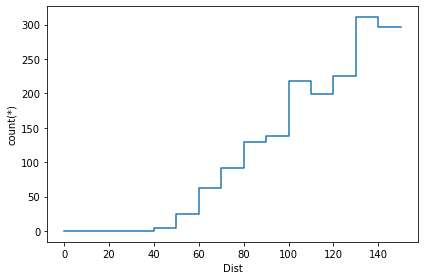

In [26]:
df_A.viz.histogram("Dist", limits=[0, 150], shape=15, show=True)

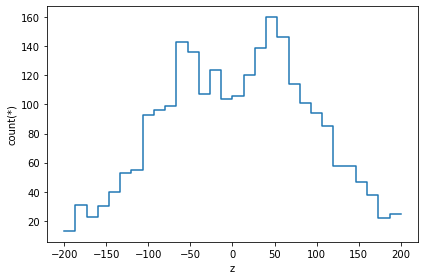

In [28]:
df_A.viz.histogram("z", limits=[-200, 200], shape=30, show=True)

In [29]:
df_A.export(join(data_dir, "A-type.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :    53.61s =  0.9m =  0.0h 
 

In [29]:
# Filter F star
JK_lower = (df_s[df_s['SpT'] == 'A9V']['J-K'].to_numpy()[0]+df_s[df_s['SpT'] == 'F0V']['J-K'].to_numpy()[0])/2
JK_upper = (df_s[df_s['SpT'] == 'F9V']['J-K'].to_numpy()[0]+df_s[df_s['SpT'] == 'G0V']['J-K'].to_numpy()[0])/2

mask_F = ((df_mask['J-K'] > JK_lower)
          *(df_mask['J-K'] < JK_upper)
          *(df_mask['M_J_lower'] > df_mask['M_J'])
          *(df_mask['M_J_upper'] < df_mask['M_J']))
df_F = df_mask[mask_F]
df_F

#,parallax,e_parallax,Jmag,Kmag,spectraltype_esphs,GLON,GLAT,J-K,M_J,Dist,z,r,M_J_upper,M_J_lower
0,10.0035,0.0115,7.983,7.709,F,5.387884774907443,-0.27860239523358316,0.2739997,2.9837596840074134,0.099965012245714,0.09611043490203337,-0.027491598284344162,2.3089693103140805,3.317244827558255
1,9.267,0.0138,7.99,7.688,F,5.484650924968532,-0.06875462698470713,0.30199957,2.8246955862237293,0.1079097874177188,0.10765483237161108,-0.007413453147999279,2.5912061955228385,3.5738238141116714
2,9.5118,0.0226,7.378,7.149,F,5.592262984691573,0.18167008134959284,0.22899961,2.2693133325994808,0.10513257217351081,0.10340243980333141,0.018994556444857653,1.8824058258693421,2.9294598416994018
3,7.3061,0.0391,8.174,7.899,F,5.660313048805103,0.31353930468348334,0.27499962,2.4924278473215775,0.1368719289360945,0.13019913659785445,0.04221504186733139,2.3194100001654814,3.326736363786801
4,6.3105,0.0233,8.788,8.55,F,5.671949456944865,0.3565266088462206,0.23799992,2.7883189621749116,0.15846604864907693,0.14850087344750237,0.05530803883505995,1.958983738915169,2.9990761262865173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"21,884",10.2079,0.0171,7.807,7.508,G,2.3560103953033384,-0.13278340942429948,0.29900026,2.851682194737461,0.09796334211737967,0.097100993180913,-0.012969715574639962,2.5629718494551508,3.54815622677741
"21,885",7.8574,0.0189,7.658,7.466,F,2.3219911016243873,-0.022617058496675422,0.19199991,2.1343943049774285,0.12726856211978516,0.12723601257858483,-0.0028781951184409012,1.598712135316473,2.671556486651339
"21,886",7.0383,0.0139,8.548,8.256,F,2.3139377126199725,0.016614244410840893,0.29200077,2.785339206847813,0.1420797635792734,0.14206015467031258,0.0023604393212059596,2.4945383658615343,3.485943968965031
"21,887",17.6699,0.0168,6.258,5.988,F,2.2896375676987906,0.08371150890345873,0.26999998,2.494170355467644,0.056593415921991644,0.05639523920751332,0.004731989058196293,2.267297412473869,3.2793612840671535


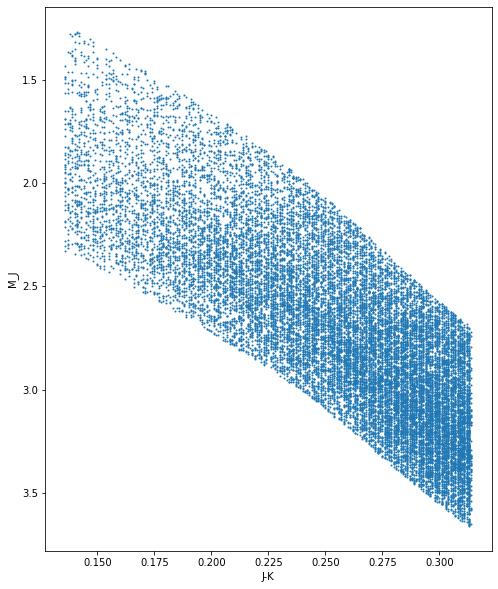

In [30]:
# HR diagram
plt.figure(figsize=(8,10))
df_F.viz.scatter("J-K", "M_J", s=1, length_limit=500_000)
plt.xlabel("J-K")
plt.ylabel("M_J")
# plt.xlim(-0, 3)
# plt.ylim(0, 12)
plt.gca().invert_yaxis()
plt.show()

In [31]:
df_F.export(join(data_dir, "F-type.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :    25.10s =  0.4m =  0.0h
 

In [32]:
# Filter G star
JK_lower = (df_s[df_s['SpT'] == 'F9V']['J-K'].to_numpy()[0]+df_s[df_s['SpT'] == 'G0V']['J-K'].to_numpy()[0])/2
JK_upper = (df_s[df_s['SpT'] == 'G3V']['J-K'].to_numpy()[0]+df_s[df_s['SpT'] == 'G4V']['J-K'].to_numpy()[0])/2

mask_G = ((df_mask['J-K'] > JK_lower)
          *(df_mask['J-K'] < JK_upper)
          *(df_mask['M_J_lower'] > df_mask['M_J'])
          *(df_mask['M_J_upper'] < df_mask['M_J']))
df_G = df_mask[mask_G]
df_G

#,parallax,e_parallax,Jmag,Kmag,spectraltype_esphs,GLON,GLAT,J-K,M_J,Dist,z,r,M_J_upper,M_J_lower
0,10.4109,0.011,7.971,7.617,G,5.396702787214521,-0.25520902421986025,0.3540001,3.058441569354164,0.09605317503770087,0.09294206544583636,-0.02424840006031478,2.996022447317366,3.9418385884703326
1,7.7619,0.0134,9.075,8.72,G,5.474200027558133,-0.08282079670399653,0.35499954,3.5248400254232584,0.12883443486775145,0.12839283136552437,-0.010657976432555517,3.0027262475877885,3.947932952352535
2,6.9705,0.0174,9.499,9.124,G,5.594908036152569,0.1806280622498026,0.375,3.7153192533148385,0.1434617315831002,0.14112776085421194,0.025772534704561957,3.1334258355824405,4.0667507596204
3,6.5238,0.0164,9.246,8.878,G,5.629195123188908,0.2766438032670601,0.36800003,3.3185034819944015,0.1532848953064165,0.14745662463718492,0.04186648993774638,3.088219147335543,4.0256537703050395
4,9.1224,0.0184,8.768,8.398,G,5.632959491544185,0.2699723287993339,0.3699999,3.5685452056214,0.10962027536613171,0.10564964009208329,0.02923625009743571,3.1011685871400037,4.037425988309095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"20,340",6.7841,0.019,9.296,8.954,G,2.382899449469505,-0.19670437947295313,0.34199905,3.4534607317173664,0.14740348756651583,0.1445609576919247,-0.02880829147946033,2.9133890821329302,3.866717347393573
"20,341",10.5129,0.021,8.703,8.36,G,2.383236684379549,-0.1847287628489864,0.3430004,3.8116127355185885,0.095121232010197,0.09350284960441015,-0.017471860089663713,2.9204567071986673,3.8731424610896976
"20,342",7.195,0.019,9.354,9.022,G,2.3422615643691134,-0.07029715778926351,0.33199978,3.639154082915854,0.13898540653231412,0.13864213650430118,-0.009762234092426702,2.840687238988165,3.800624762716514
"20,343",11.0402,0.0139,8.229,7.864,G,2.3384744226640173,-0.06071700538930063,0.36500025,3.443884796430604,0.09057806923787612,0.09041116001859326,-0.005496250626909599,3.06871893712469,4.007926306476991


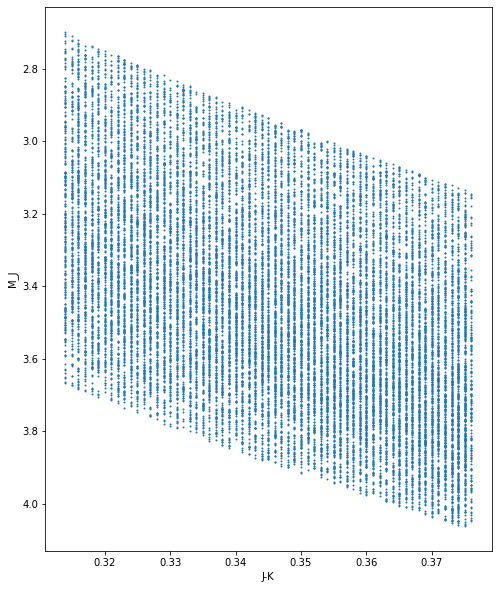

In [33]:
# HR diagram for gaia filter
plt.figure(figsize=(8,10))
df_G.viz.scatter("J-K", "M_J", s=1, length_limit=500_000)
plt.xlabel("J-K")
plt.ylabel("M_J")
# plt.xlim(-0, 3)
# plt.ylim(0, 12)
plt.gca().invert_yaxis()
plt.show()

In [34]:
df_G.export(join(data_dir, "G-type.hdf5"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :    25.41s =  0.4m =  0.0h
 